In [1]:
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def getCsvData(fileName):
    data = pd.read_csv(fileName)
    data.drop('Province/State', axis=1, inplace=True)
    data.drop('Lat', axis=1, inplace=True)
    data.drop('Long', axis=1, inplace=True)
    data.columns = np.concatenate((np.array(['Country/Region']),np.arange(len(data.columns[1:]))))
    dataDict = {'Brazil':[],'India':[],'United Kingdom':[],'Russia':[],'US':[]}
    for index,row in data.iterrows():
        for key in dataDict:
            if row['Country/Region'] == key:
                d = data.iloc[index][1:].astype(np.float32).values
                m = np.zeros_like(d)
                for j in range(1,len(d)):
                    m[j] = d[j] - d[j-1]
                dataDict[key].append(m)
    dataDict['United Kingdom'] = [np.sum(np.array(dataDict['United Kingdom']),axis=0)]
    return dataDict

In [3]:
Confirmed = getCsvData('./time_series_covid19_confirmed_global.csv')
Deaths = getCsvData('./time_series_covid19_deaths_global.csv')

In [4]:
timeLength = len(Confirmed['Brazil'][0])
print(timeLength)

576


In [5]:
data = {'Brazil':None,'India':None,'United Kingdom':None,'Russia':None,'US':None}
data['Brazil'] = np.concatenate((Confirmed['Brazil'][0].reshape(-1,1),Deaths['Brazil'][0].reshape(-1,1)),axis=1)
data['India'] = np.concatenate((Confirmed['India'][0].reshape(-1,1),Deaths['India'][0].reshape(-1,1)),axis=1)
data['United Kingdom'] = np.concatenate((Confirmed['United Kingdom'][0].reshape(-1,1),Deaths['United Kingdom'][0].reshape(-1,1)),axis=1)
data['Russia'] = np.concatenate((Confirmed['Russia'][0].reshape(-1,1),Deaths['Russia'][0].reshape(-1,1)),axis=1)
data['US'] = np.concatenate((Confirmed['US'][0].reshape(-1,1),Deaths['US'][0].reshape(-1,1)),axis=1)

In [6]:
np.max(data['Brazil'],axis=0)

array([115228.,   4249.], dtype=float32)

In [7]:
sequence_length= 7
delay = 1
def func(country):
    dataCountry = []
    for i in range(timeLength - sequence_length -delay + 1):
        dataCountry.append(data[country][i:i+sequence_length+delay])
    dataCountry = np.array(dataCountry)
    x_train = dataCountry[:,:sequence_length]/np.max(data[country],axis=0)
    y_train = dataCountry[:,-1,:]/np.max(data[country],axis=0)
    return x_train,y_train

In [8]:
x_Brazil,y_Brazil = func('Brazil')
x_India,y_India = func('India')
x_Russia,y_Russia = func('Russia')
x_UK,y_UK = func('United Kingdom')
x_US,y_US = func('US')

In [9]:
y_Brazil[-2]

array([0.36199534, 0.25041187], dtype=float32)

In [10]:
from sklearn.model_selection import train_test_split
train_x_Brazil,test_x_Brazil,train_y_Brazil,test_y_Brazil = train_test_split(x_Brazil,y_Brazil)
train_x_India,test_x_India,train_y_India,test_y_India = train_test_split(x_India,y_India)
train_x_Russia,test_x_Russia,train_y_Russia,test_y_Russia = train_test_split(x_Russia,y_Russia)
train_x_UK,test_x_UK,train_y_UK,test_y_UK = train_test_split(x_UK,y_UK)
train_x_US,test_x_US,train_y_US,test_y_US = train_test_split(x_US,y_US)

In [11]:
class Mydataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return len(self.features)

In [12]:
train_Brazil_dataset = Mydataset(train_x_Brazil,train_y_Brazil)
test_Brazil_dataset = Mydataset(test_x_Brazil,test_y_Brazil)
train_India_dataset = Mydataset(train_x_India,train_y_India)
test_India_dataset = Mydataset(test_x_India,test_y_India)
train_Russia_dataset = Mydataset(train_x_Russia,train_y_Russia)
test_Russia_dataset = Mydataset(test_x_Russia,test_y_Russia)
train_UK_dataset = Mydataset(train_x_UK,train_y_UK)
test_UK_dataset = Mydataset(test_x_UK,test_y_UK)
train_US_dataset = Mydataset(train_x_US,train_y_US)
test_US_dataset = Mydataset(test_x_US,test_y_US)

In [13]:
BTACH_SIZE = 64
train_Brazil_dl = torch.utils.data.DataLoader(train_Brazil_dataset,batch_size=BTACH_SIZE,shuffle=True)
test_Brazil_dl = torch.utils.data.DataLoader(test_Brazil_dataset,batch_size=BTACH_SIZE)
train_India_dl = torch.utils.data.DataLoader(train_India_dataset,batch_size=BTACH_SIZE,shuffle=True)
test_India_dl = torch.utils.data.DataLoader(test_India_dataset,batch_size=BTACH_SIZE)
train_Russia_dl = torch.utils.data.DataLoader(train_Russia_dataset,batch_size=BTACH_SIZE,shuffle=True)
test_Russia_dl = torch.utils.data.DataLoader(test_Russia_dataset,batch_size=BTACH_SIZE)
train_UK_dl = torch.utils.data.DataLoader(train_UK_dataset,batch_size=BTACH_SIZE,shuffle=True)
test_UK_dl = torch.utils.data.DataLoader(test_UK_dataset,batch_size=BTACH_SIZE)
train_US_dl = torch.utils.data.DataLoader(train_US_dataset,batch_size=BTACH_SIZE,shuffle=True)
test_US_dl = torch.utils.data.DataLoader(test_US_dataset,batch_size=BTACH_SIZE)

In [14]:
hidden_size = 128
class Net(nn.Module):
    # GRU实现 
    def __init__(self,hidden_size):
        super().__init__()
        self.num_layers = 3
        self.rnn = nn.GRU(2,hidden_size,num_layers=self.num_layers,batch_first=True)
        self.fc1 = nn.Linear(hidden_size*self.num_layers, 256)
        self.fc2 = nn.Linear(256, 2)
    def forward(self,inputs):
        _,hn = self.rnn(inputs)
        x = hn.permute(1,0,2)
        x = torch.flatten(x,start_dim=1)
        x = F.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x.squeeze()
    
# class Net(nn.Module):
#     # LSTM实现 
#     def __init__(self, hidden_size):
#         super(Net, self).__init__()
#         self.rnn = nn.LSTM(2, hidden_size,num_layers=4,batch_first=True)
#         self.fc1 = nn.Linear(hidden_size, 256)
#         self.fc2 = nn.Linear(256, 1)

#     def forward(self, inputs):
#         _, s_o = self.rnn(inputs)
#         s_o = s_o[-1]
#         x = F.dropout(F.relu(self.fc1(s_o)))
#         x = self.fc2(x)
#         x = torch.sum(x,axis=0)
#         return torch.squeeze(x)

In [15]:
model_Brazil = Net(hidden_size)
model_India = Net(hidden_size)
model_Russia = Net(hidden_size)
model_UK = Net(hidden_size)
model_US = Net(hidden_size)

In [16]:
if torch.cuda.is_available():
    model_India.to('cuda')
    model_Brazil.to('cuda')
    model_Russia.to('cuda')
    model_UK.to('cuda')
    model_US.to('cuda')

In [17]:
loss_fn = nn.MSELoss()
optimizer_Brazil = torch.optim.Adam(model_Brazil.parameters(), lr=1e-3)
optimizer_India = torch.optim.Adam(model_India.parameters(), lr=1e-3)
optimizer_Russia = torch.optim.Adam(model_Russia.parameters(), lr=1e-3)
optimizer_UK = torch.optim.Adam(model_UK.parameters(), lr=1e-3)
optimizer_US = torch.optim.Adam(model_US.parameters(), lr=1e-3)

In [18]:
def fit(epoch, model, trainloader, testloader,optimizer):
    total = 0
    running_loss = 0
    
    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            total += y.size(0)
            running_loss += loss.item()
#    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset)
        
        
    test_total = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
        
#     print('epoch: ', epoch, 
#           'loss： ', round(epoch_loss, 6),
#           'test_loss： ', round(epoch_test_loss, 6),
#              )
        
    return epoch_loss, epoch_test_loss

In [19]:
def pltLoss(train_loss,test_loss):
    plt.figure()
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train_loss','test_loss'])

In [20]:
train_loss = []
test_loss = []
epochs = 200
bestModel_Brazil = None
bestLoss = np.inf
for epoch in tqdm(range(epochs),total=epochs,smoothing=0.9):
    epoch_loss, epoch_test_loss = fit(epoch,model_Brazil,train_Brazil_dl,test_Brazil_dl,optimizer_Brazil)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)
    if epoch_test_loss<bestLoss:
        bestLoss = epoch_test_loss
        bestModel_Brazil = model_Brazil

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.43it/s]


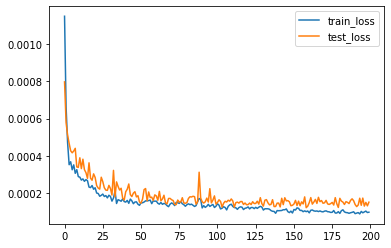

In [21]:
pltLoss(train_loss,test_loss)

In [22]:
train_loss = []
test_loss = []
epochs = 200
bestModel_India = None
bestLoss = np.inf
for epoch in tqdm(range(epochs),total=epochs,smoothing=0.9):
    epoch_loss, epoch_test_loss = fit(epoch,model_India,train_India_dl,test_India_dl,optimizer_India)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)
    if epoch_test_loss < bestLoss:
        bestLoss = epoch_test_loss
        bestModel_India = model_India

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.25it/s]


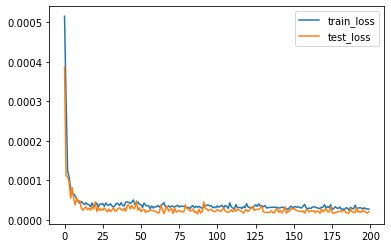

In [23]:
pltLoss(train_loss,test_loss)

In [24]:
train_loss = []
test_loss = []
epochs = 200
bestModel_Russia = None
bestLoss = np.inf
for epoch in tqdm(range(epochs),total=epochs,smoothing=0.9):
    epoch_loss, epoch_test_loss = fit(epoch,model_Russia,train_Russia_dl,test_Russia_dl,optimizer_Russia)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)
    if epoch_test_loss<bestLoss:
        bestLoss = epoch_test_loss
        bestModel_Russia = model_Russia

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.32it/s]


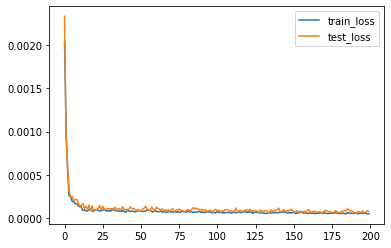

In [25]:
pltLoss(train_loss,test_loss)

In [26]:
train_loss = []
test_loss = []
epochs = 200
bestModel_UK = None
bestLoss = np.inf
for epoch in tqdm(range(epochs),total=epochs,smoothing=0.9):
    epoch_loss, epoch_test_loss = fit(epoch,model_UK,train_UK_dl,test_UK_dl,optimizer_UK)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)
    if epoch_test_loss<bestLoss:
        bestLoss = epoch_test_loss
        bestModel_UK = model_UK

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.33it/s]


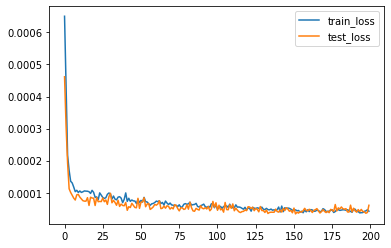

In [27]:
pltLoss(train_loss,test_loss)

In [28]:
train_loss = []
test_loss = []
epochs = 200
bestModel_US = None
bestLoss = np.inf
for epoch in tqdm(range(epochs),total=epochs,smoothing=0.9):
    epoch_loss, epoch_test_loss = fit(epoch,model_US,train_US_dl,test_US_dl,optimizer_US)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)
    if epoch_test_loss<bestLoss:
        bestLoss = epoch_test_loss
        bestModel_US = model_US

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.38it/s]


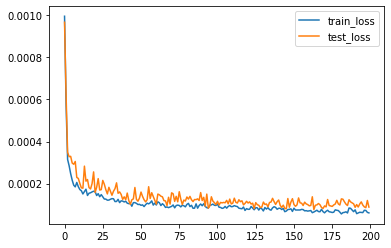

In [29]:
pltLoss(train_loss,test_loss)

# India Brazil Russia UK US未来预测

In [30]:
x4pred_bra = data['Brazil'][-sequence_length:]/np.max(data['Brazil'],axis=0)
x4pred_ind = data['India'][-sequence_length:]/np.max(data['India'],axis=0)
x4pred_rus = data['Russia'][-sequence_length:]/np.max(data['Russia'],axis=0)
x4pred_UK = data['United Kingdom'][-sequence_length:]/np.max(data['United Kingdom'],axis=0)
x4pred_US = data['US'][-sequence_length:]/np.max(data['US'],axis=0)
ptr = 0
POINT_NUM = 61
while ptr<POINT_NUM:
    x_input = np.expand_dims(x4pred_bra[ptr:ptr+sequence_length],0)
    out = bestModel_Brazil(torch.as_tensor(x_input,dtype=torch.float).cuda())
    out = out.cpu().detach().numpy().reshape(1,-1)
    x4pred_bra = np.concatenate((x4pred_bra,out),axis=0)
    
    x_input = np.expand_dims(x4pred_ind[ptr:ptr+sequence_length],0)
    out = bestModel_India(torch.as_tensor(x_input,dtype=torch.float).cuda())
    out = out.cpu().detach().numpy().reshape(1,-1)
    x4pred_ind = np.concatenate((x4pred_ind,out),axis=0)
    
    x_input = np.expand_dims(x4pred_rus[ptr:ptr+sequence_length],0)
    out = bestModel_Russia(torch.as_tensor(x_input,dtype=torch.float).cuda())
    out = out.cpu().detach().numpy().reshape(1,-1)
    x4pred_rus = np.concatenate((x4pred_rus,out),axis=0)
    
    x_input = np.expand_dims(x4pred_US[ptr:ptr+sequence_length],0)
    out = bestModel_US(torch.as_tensor(x_input,dtype=torch.float).cuda())
    out = out.cpu().detach().numpy().reshape(1,-1)
    x4pred_US = np.concatenate((x4pred_US,out),axis=0)
    
    x_input = np.expand_dims(x4pred_UK[ptr:ptr+sequence_length],0)
    out = bestModel_UK(torch.as_tensor(x_input,dtype=torch.float).cuda())
    out = out.cpu().detach().numpy().reshape(1,-1)
    x4pred_UK = np.concatenate((x4pred_UK,out),axis=0)
    
    ptr += 1
x4pred_bra = x4pred_bra[-POINT_NUM:,0]*np.max(data['Brazil'],axis=0)[0]
x4pred_ind = x4pred_ind[-POINT_NUM:,0]*np.max(data['India'],axis=0)[0]
x4pred_rus = x4pred_rus[-POINT_NUM:,0]*np.max(data['Russia'],axis=0)[0]
x4pred_US = x4pred_US[-POINT_NUM:,0]*np.max(data['United Kingdom'],axis=0)[0]
x4pred_UK = x4pred_UK[-POINT_NUM:,0]*np.max(data['US'],axis=0)[0]

In [31]:
x4pred_UK

array([ 1.40398812e+05,  1.16050656e+05,  9.03233672e+04,  9.19518750e+04,
        7.94171328e+04,  7.32300156e+04,  6.85443828e+04,  6.43728984e+04,
        5.08750000e+04,  4.43473672e+04,  3.80879180e+04,  3.07089922e+04,
        2.49617734e+04,  2.16360117e+04,  1.89035957e+04,  1.14585391e+04,
        1.21263428e+04,  8.06635498e+03,  1.11855215e+04,  7.49371094e+03,
       -2.93406030e+03, -3.05805078e+03,  2.09377785e+01, -8.20525684e+03,
        2.40248306e+02,  3.81867645e+02, -1.10304238e+04,  2.70936157e+03,
       -7.67668311e+03, -1.19071670e+04, -6.87537305e+03,  9.47707031e+02,
        1.36018774e+03,  1.65224890e+03, -1.07454502e+04,  2.98349805e+03,
        2.79689136e+03, -9.17402893e+02,  6.84106738e+03,  5.44203613e+03,
       -2.68068262e+03, -3.43974365e+03,  6.69899561e+03, -4.30148584e+03,
        4.44324609e+03,  6.95483691e+03,  6.42692090e+03, -1.09396484e+03,
       -3.16291870e+03, -3.97041895e+03, -5.62998584e+03, -1.17659883e+04,
       -1.09940908e+04, -

In [32]:
def mPlot(string,d):
    plt.figure()
    plt.plot(np.arange(timeLength),data[string][:,0])
    plt.plot(np.arange(timeLength,timeLength+POINT_NUM),d)

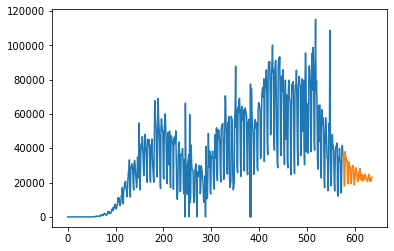

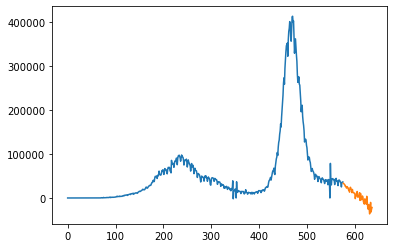

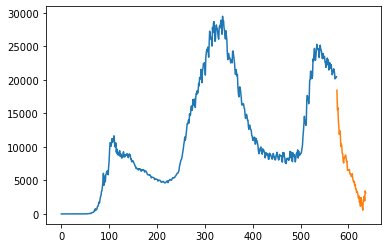

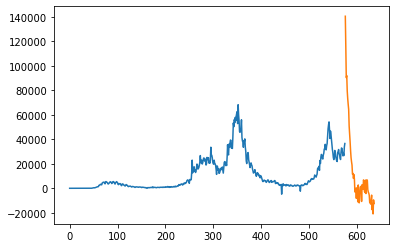

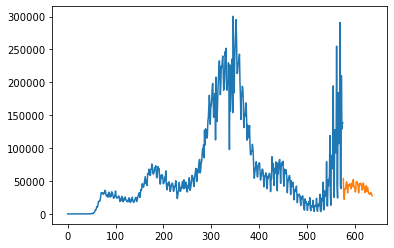

In [33]:
mPlot('Brazil',x4pred_bra)
mPlot('India',x4pred_ind)
mPlot('Russia',x4pred_rus)
mPlot('United Kingdom',x4pred_UK)
mPlot('US',x4pred_US)

In [34]:
def calRes(x1,x2):
    temp = np.concatenate((x1,x2))
    return np.cumsum(temp)

In [35]:
bra = calRes(data['Brazil'][:,0],x4pred_bra)
ind = calRes(data['India'][:,0],x4pred_ind)
rus = calRes(data['Russia'][:,0],x4pred_rus)
UK = calRes(data['United Kingdom'][:,0],x4pred_UK)
US = calRes(data['US'][:,0],x4pred_US)

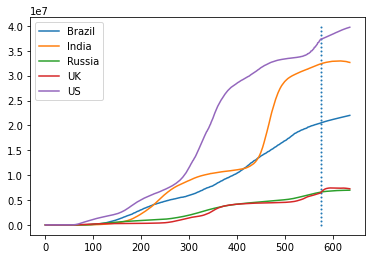

In [36]:
plt.figure()
plt.plot(bra)
plt.plot(ind)
plt.plot(rus)
plt.plot(UK)
plt.plot(US)
plt.scatter([timeLength for _ in range(50)],np.linspace(0,np.max(US)),s=1)
plt.legend(['Brazil','India','Russia','UK','US'])